In [1]:
import warnings
warnings.filterwarnings("ignore")

import pysodb
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import harmonypy as hm

from matplotlib import rcParams
from pathlib import Path
from tqdm import tqdm

import iSp3D as MODEL
from iSp3D import Func
from iSp3D import iSpaNet
from iSp3D.Classifier import iSpaNetClassifier
from iSp3D.Utils import align_spatial_slices
from iSp3D.Attribution import compute_and_summary_by_cluster
from iSp3D.Metrics import compute_ARI, compute_NMI, compute_HOM, compute_COM, compute_PAS, compute_CHAOS
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.2'
os.environ['R_USER'] = r'C:\Users\CLEARLOVE\.conda\envs\STG\Lib\site-packages\rpy2'

def inverse_pca_transform(pca, recon_pca_data, adata):
    recon_scaled = pca.inverse_transform(recon_pca_data)
    return recon_scaled

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]

    LISI = 2 * (1 / LISI_domain_norm) * LISI_batch_norm / (1 / LISI_domain_norm + LISI_batch_norm)
    return LISI

def get_data(proj_list, config):
    global graph_dict
    sodb = pysodb.SODB()
    adata_dict = sodb.load_dataset('Zeng2023Integrative')
    adata_dict = {k: v for k, v in adata_dict.items() if k.endswith('replicate_1')}
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        matching_keys = [k for k in adata_dict.keys() if k.startswith(proj_name)]
        adata_tmp = adata_dict[matching_keys[0]]
        adata_tmp.var_names_make_unique()
        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])

        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)
    adata.obsm['X_original'] = adata.X.copy()

    pca = PCA(n_components=200, random_state=42)
    adata_X = pca.fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X

    return adata, graph_dict, pca

In [ ]:
with open(r"C:\Code\iSpa3D\Config\Config_ADMB.yaml", 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

proj_list = ['8months-control', '8months-disease', '13months-control', '13months-disease']

num_cluster = 12

adata, graph_dict, pca = get_data(proj_list, config['data'])

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

net.train()

load experimentonths-control-replicate_1] in dataset[Zeng2023Integrative]
load experimentonths-control-replicate_2] in dataset[Zeng2023Integrative]
load experimentonths-disease-replicate_1] in dataset[Zeng2023Integrative]
load experimentonths-disease-replicate_2] in dataset[Zeng2023Integrative]
load experimentonths-control-replicate_1] in dataset[Zeng2023Integrative]
load experimentonths-control-replicate_2] in dataset[Zeng2023Integrative]
load experimentonths-disease-replicate_1] in dataset[Zeng2023Integrative]
load experimentonths-disease-replicate_2] in dataset[Zeng2023Integrative]


100%|██████████| 4/4 [00:27<00:00,  6.88s/it]
Epoch 495 total loss=4.071 recon loss=0.973 tri loss=0.000 disc loss=1.046 cluster loss=3.136:  50%|█████     | 500/1000 [00:18<00:17, 28.47it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Epoch 545 total loss=4.389 recon loss=1.107 tri loss=0.277 disc loss=1.216 cluster loss=3.115:  55%|█████▍    | 549/1000 [01:11<00:32, 13.96it/s]

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=4.321 recon loss=1.065 tri loss=0.250 disc loss=1.231 cluster loss=3.086:  60%|█████▉    | 599/1000 [01:55<00:29, 13.68it/s]

fitting ...
  |======================================================================| 100%


Epoch 645 total loss=4.262 recon loss=1.044 tri loss=0.203 disc loss=1.250 cluster loss=3.059:  65%|██████▍   | 649/1000 [02:46<00:26, 13.04it/s]

fitting ...
  |======================================================================| 100%


Epoch 695 total loss=4.254 recon loss=1.036 tri loss=0.239 disc loss=1.247 cluster loss=3.036:  70%|██████▉   | 699/1000 [03:30<00:20, 14.41it/s]

fitting ...
  |======================================================================| 100%


Epoch 745 total loss=4.230 recon loss=1.018 tri loss=0.235 disc loss=1.248 cluster loss=3.028:  75%|███████▌  | 750/1000 [04:16<00:18, 13.20it/s]

fitting ...
  |======================================================================| 100%


Epoch 795 total loss=4.231 recon loss=1.020 tri loss=0.224 disc loss=1.275 cluster loss=3.021:  80%|███████▉  | 799/1000 [05:04<00:14, 13.49it/s]

fitting ...
  |======================================================================| 100%


Epoch 845 total loss=4.223 recon loss=1.010 tri loss=0.236 disc loss=1.271 cluster loss=3.014:  85%|████████▍ | 849/1000 [05:42<00:10, 14.43it/s]

fitting ...
  |======================================================================| 100%


Epoch 895 total loss=4.201 recon loss=1.008 tri loss=0.213 disc loss=1.254 cluster loss=3.015:  90%|████████▉ | 899/1000 [06:21<00:07, 13.61it/s]

fitting ...
  |===================================                                   |  50%

Epoch 895 total loss=4.201 recon loss=1.008 tri loss=0.213 disc loss=1.254 cluster loss=3.015:  90%|████████▉ | 899/1000 [06:34<00:07, 13.61it/s]

  |======================================================================| 100%


Epoch 945 total loss=4.201 recon loss=1.000 tri loss=0.225 disc loss=1.257 cluster loss=3.013:  95%|█████████▍| 949/1000 [07:15<00:03, 14.02it/s]

fitting ...
  |======================================================================| 100%


Epoch 995 total loss=4.175 recon loss=0.992 tri loss=0.208 disc loss=1.239 cluster loss=3.011: 100%|█████████▉| 995/1000 [07:54<00:02,  2.10it/s]

Stop trainning because of loss convergence


In [3]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
recon_original = inverse_pca_transform(pca, recon, adata)
adata.obsm['X_reconstructed'] = recon_original

print(adata)

AnnData object with n_obs × n_vars = 35098 × 2000
    obs: 'ct_top', 'ct_sub', 'sample', 'leiden', 'batch_name', 'slice_id', 'proj_name', 'batch', 'Tmp_domain'
    var: 'highly_variable-0-0-0', 'means-0-0-0', 'dispersions-0-0-0', 'dispersions_norm-0-0-0', 'highly_variable-1-0-0', 'means-1-0-0', 'dispersions-1-0-0', 'dispersions_norm-1-0-0', 'highly_variable-1-0', 'means-1-0', 'dispersions-1-0', 'dispersions_norm-1-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap', 'spatial', 'X_original', 'latent', 'recon', 'X_reconstructed'
    layers: 'count'


In [4]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

fitting ...
  |======================================================================| 100%


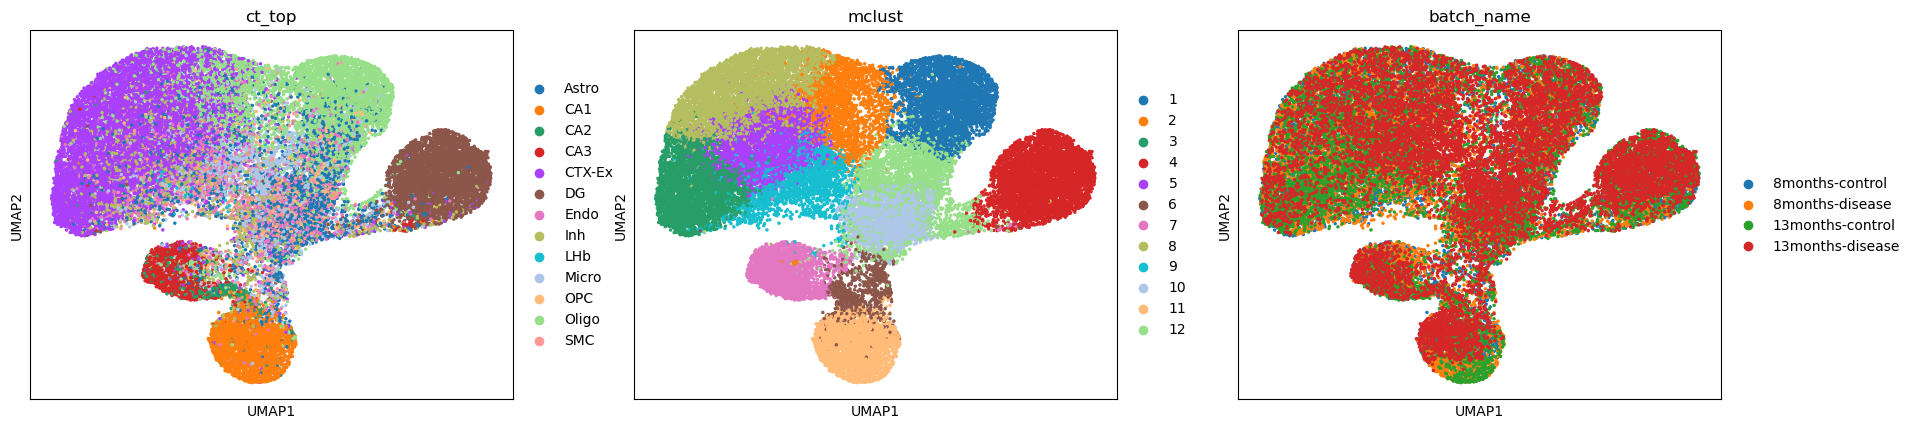

In [5]:
# %%
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['ct_top', 'mclust', 'batch_name'], show=True, size=25, save=False)

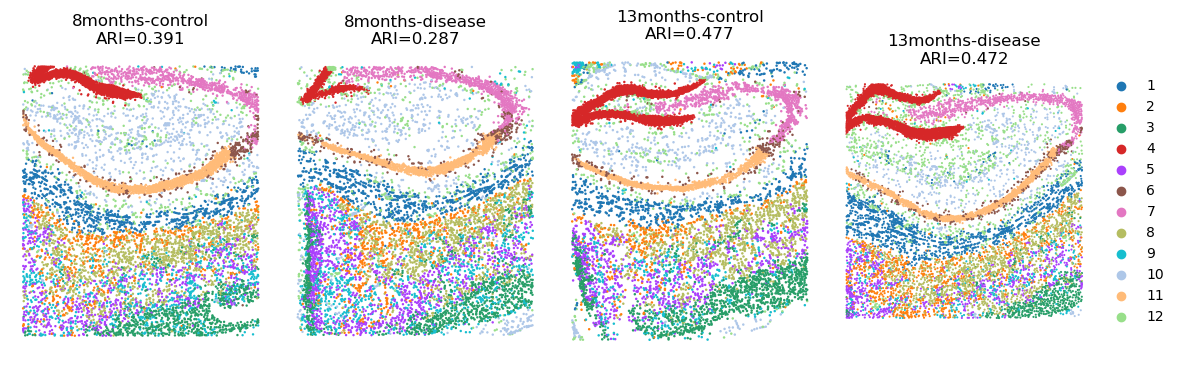

In [ ]:
sub_adata = adata[~pd.isnull(adata.obs['ct_top'])]
Batch_list = []
for section_id in proj_list:
    Batch_list.append(sub_adata[sub_adata.obs['batch_name'] == section_id])

spot_size = 200
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['ct_top'], Batch_list[bb].obs['mclust']), 3))

fig, ax = plt.subplots(1, 4, figsize=(14, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    if idx == len(proj_list) - 1:  # 在最后一个子图显示图例
        _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                          legend_loc='right margin', legend_fontsize=10, show=False, ax=ax[idx], frameon=False,
                          spot_size=spot_size)
    else:
        _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                          legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                          spot_size=spot_size)
    _sc_[0].set_title(f"{proj_list[idx]}\nARI={ARI_list[idx]}", size=title_size)

# plt.savefig(f'clusters_STAR+.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

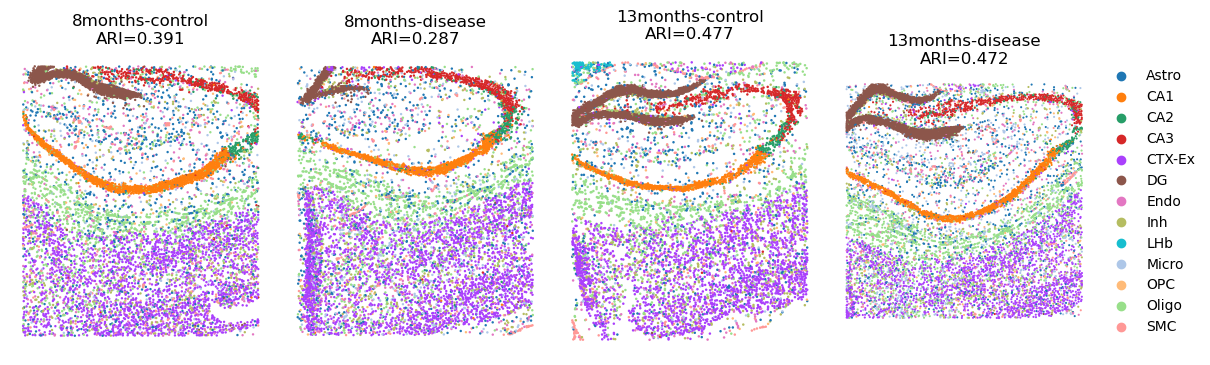

In [ ]:
sub_adata = adata[~pd.isnull(adata.obs['ct_top'])]
Batch_list = []
for section_id in proj_list:
    Batch_list.append(sub_adata[sub_adata.obs['batch_name'] == section_id])

spot_size = 200
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['ct_top'], Batch_list[bb].obs['mclust']), 3))

fig, ax = plt.subplots(1, 4, figsize=(14, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    if idx == len(proj_list) - 1:  # 在最后一个子图显示图例
        _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['ct_top'], title=[''],
                          legend_loc='right margin', legend_fontsize=10, show=False, ax=ax[idx], frameon=False,
                          spot_size=spot_size)
    else:
        _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['ct_top'], title=[''],
                          legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                          spot_size=spot_size)
    _sc_[0].set_title(f"{proj_list[idx]}\nARI={ARI_list[idx]}", size=title_size)

# plt.savefig(f'clusters_STAR+.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [8]:
from iSp3D.Utils import align_spatial_slices
import matplotlib.pyplot as plt

# Perform spatial alignment using Utils function
adata = align_spatial_slices(adata, proj_list, n_sample=6000, random_seed=1234)

Using 6000 samples for alignment

Aligning slice 8months-control and 8months-disease
Found 1896 MNN pairs

Aligning slice 8months-disease and 13months-control
Found 1681 MNN pairs

Aligning slice 13months-control and 13months-disease
Found 1657 MNN pairs

Spatial alignment completed


In [9]:
with open('C:\\Code\\iSpa3D\\Config\\classifier_config.yaml', 'r', encoding='utf-8') as f:
    classifier_config = yaml.load(f.read(), Loader=yaml.FullLoader)
    
cluster_labels_original = adata.obs['mclust'].values.astype(int)
 
unique_labels = np.unique(cluster_labels_original)
label_mapping = {old: new for new, old in enumerate(sorted(unique_labels))}
cluster_labels_for_training = np.array([label_mapping[label] for label in cluster_labels_original])


classifier = iSpaNetClassifier(in_features=config['model']['latent_dim'], n_classes=len(unique_labels), config=classifier_config, device=device)
classifier.prepare_data(g3net_model=net, adata=adata, target_labels=cluster_labels_for_training)
classifier.train(epochs=classifier.max_epochs, verbose=True, early_stop_patience=50)

Epoch [ 10/300] Train Loss: 0.8263, Train Acc: 0.6920 | Val Loss: 0.5497, Val Acc: 0.8028
Epoch [ 20/300] Train Loss: 0.8035, Train Acc: 0.6972 | Val Loss: 0.5751, Val Acc: 0.7999
Epoch [ 30/300] Train Loss: 0.8035, Train Acc: 0.6974 | Val Loss: 0.5690, Val Acc: 0.7988
Epoch [ 40/300] Train Loss: 0.8044, Train Acc: 0.6987 | Val Loss: 0.5754, Val Acc: 0.7971
Epoch [ 50/300] Train Loss: 0.7864, Train Acc: 0.7062 | Val Loss: 0.5786, Val Acc: 0.7968
Epoch [ 60/300] Train Loss: 0.7851, Train Acc: 0.7092 | Val Loss: 0.5737, Val Acc: 0.7954

Early stopping at epoch 60


In [ ]:
res_df = compute_and_summary_by_cluster(
    net=net,
    cluster_key='mclust',
    classifier=classifier,
    top_k=100,
    pca=pca, 
    target_clusters=None, 
    spatial_radius=1200,
    spatial_ratio=0.5
)

Computing attributions for 12 clusters...


Cluster attribution:   0%|          | 0/12 [00:00<?, ?it/s]

Cluster 1: neighbors = ['12', '2', '8', '10']


Cluster attribution:   8%|▊         | 1/12 [02:21<25:56, 141.48s/it]

Cluster 10: neighbors = ['12', '6', '11']


Cluster attribution:  17%|█▋        | 2/12 [05:02<25:30, 153.02s/it]

Cluster 11: neighbors = ['10', '6', '12']


Cluster attribution:  25%|██▌       | 3/12 [07:35<22:56, 152.99s/it]

Cluster 12: neighbors = ['1', '2', '7', '10', '4', '6', '11']


Cluster attribution:  33%|███▎      | 4/12 [09:54<19:41, 147.63s/it]

Cluster 2: neighbors = ['12', '1', '9', '5', '8']


Cluster attribution:  42%|████▏     | 5/12 [12:08<16:37, 142.56s/it]

Cluster 3: neighbors = ['8', '5', '9', '2']


Cluster attribution:  50%|█████     | 6/12 [14:27<14:07, 141.25s/it]

Cluster 4: neighbors = ['12', '7', '10']


Cluster attribution:  58%|█████▊    | 7/12 [16:42<11:36, 139.21s/it]

Cluster 5: neighbors = ['2', '8', '9', '3']


Cluster attribution:  67%|██████▋   | 8/12 [19:06<09:22, 140.67s/it]

Cluster 6: neighbors = ['7', '11']


Cluster attribution:  75%|███████▌  | 9/12 [20:38<06:16, 125.55s/it]

Cluster 7: neighbors = ['12', '6', '4']


Cluster attribution:  83%|████████▎ | 10/12 [22:56<04:18, 129.41s/it]

Cluster 8: neighbors = ['1', '2', '5', '9', '3']


Cluster attribution:  92%|█████████▏| 11/12 [25:11<02:11, 131.11s/it]

Cluster 9: neighbors = ['2', '5', '8', '3']


Cluster attribution: 100%|██████████| 12/12 [27:28<00:00, 137.36s/it]


In [ ]:
gene_info_file = r"C:\Code\Data\STARmap_PLUS_ad\expression_matrix_normalized.csv"
gene_info_df = pd.read_csv(gene_info_file, index_col=0)

real_gene_names = gene_info_df.index.tolist()

first_var = str(adata.var_names[0])
if first_var.isdigit():
    idx_to_gene = {}
    for var_name in adata.var_names:
        idx = int(var_name)
        if idx < len(real_gene_names):
            idx_to_gene[var_name] = real_gene_names[idx]
        else:
            idx_to_gene[var_name] = f"Gene_{var_name}"
    
    new_var_names = [idx_to_gene.get(str(var_name), str(var_name)) for var_name in adata.var_names]
    adata.var_names = new_var_names
else:
    idx_to_gene = {str(i): gene for i, gene in enumerate(adata.var_names)}


映射示例: [('0', 'A2m'), ('2', 'Aak1'), ('3', 'Abca2'), ('4', 'Abca7'), ('5', 'Abcc9')]


In [12]:
final_dfs, top_dict, per_method_dfs = res_df

for cluster_id, gene_list in top_dict.items():
    genes = []
    for g in gene_list[:20]:
        if isinstance(g, (int, np.integer)):
            gene_name = idx_to_gene.get(str(g), f"Gene_{g}")
        elif isinstance(g, str):
            if g.isdigit():
                gene_name = idx_to_gene.get(g, g)
            else:
                gene_name = g
        else:
            gene_name = str(g)
        genes.append(gene_name)
    
    print(f"\n{cluster_id}:")
    print(f"  {genes}")


1:
  ['Plp1', 'Tspan2', 'Mobp', 'Edil3', 'Car2', 'Cntn2', 'Ugt8a', 'Bin1', 'Ndrg1', 'Sox10', 'Aspa', 'Mbp', 'Trf', 'Stmn4', 'Il33', 'Tubb4a', 'Plxnb3', 'Opalin', 'Plekhb1', 'Dnm3']

10:
  ['C1ql3', 'Edil3', 'Plp1', 'Lrrtm4', 'Bin1', 'Lrp1b', 'Stmn4', 'Cntn2', 'Tspan2', 'Prox1', 'Olfm2', 'Ppfia2', 'Btbd9', 'Ugt8a', 'Aspa', 'Pyy', 'Grm3', 'Plxnb3', 'Car2', 'St18']

11:
  ['Rasgrp1', 'Ppp3r1', 'Nrgn', 'Hpca', 'Grin2b', 'Snap25', 'Vsnl1', 'Dnm1', 'Tmsb4x', 'Dkk3', 'Cnksr2', 'Brinp1', 'Prkcb', 'Dgkz', 'Rprml', 'Actr2', 'Pde1a', 'Nefl', 'Grin1', 'Nsf']

12:
  ['Cst3', 'Bsg', 'Ly6e', 'Hexb', 'Flt1', 'C1qa', 'Slco1a4', 'Epas1', 'Pltp', 'Cxcl12', 'Sparc', 'S1pr1', 'Atp1a2', 'Ctss', 'Itgb5', 'P2ry12', 'Fcrls', 'Selplg', 'Rgs5', 'Vtn']

2:
  ['Plp1', 'Car2', 'Tspan2', 'Mobp', 'Mbp', 'Cntn2', 'Ndrg1', 'Aspa', 'Sox10', 'Ugt8a', 'Il33', 'Tubb4a', 'Stmn4', 'Trf', 'Plekhb1', 'Ermn', 'Edil3', 'Dnm3', 'Neat1', 'St18']

3:
  ['C1ql3', 'Nrgn', 'Gria1', 'Cplx2', 'Epha7', 'Grin2b', 'Ppfia2', 'Sphkap', 'Nr3

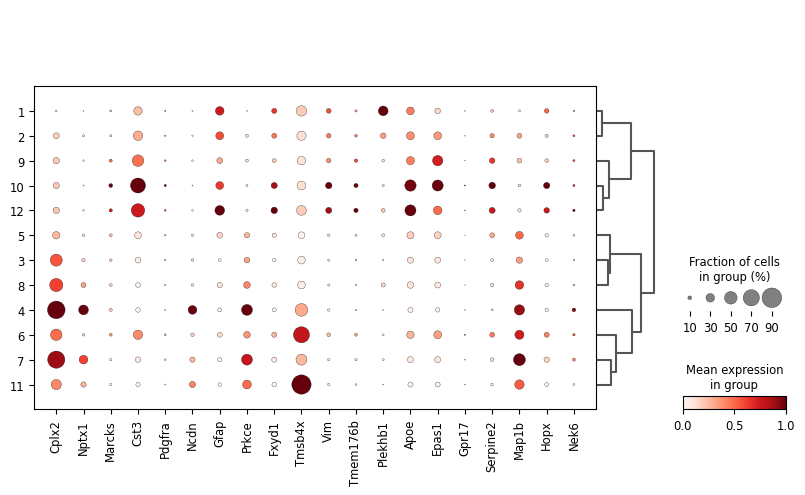

In [67]:
adata.obs['re_mclust'] = adata.obs['mclust'].astype(str)
dg = ['Cplx2', 'Nptx1', 'Marcks', 'Cst3', 'Pdgfra', 'Ncdn', 'Gfap', 'Prkce', 'Fxyd1', 'Tmsb4x', 'Vim', 'Tmem176b', 'Plekhb1', 'Apoe', 'Epas1', 'Gpr17', 'Serpine2', 'Map1b', 'Hopx', 'Nek6']

sc.pl.dotplot(adata, dg, groupby='re_mclust', dendrogram=True, swap_axes=False,standard_scale='var')